In [203]:
library(ggplot2)
library(reshape2)
library(rstatix)
library(dplyr)
library(tidyverse)
library(RColorBrewer)
library(ARTool)
library(readxl) 
library(ggsignif) 
library(seewave)
library(gsignal)
library(spectral)
library(onion)
library(fANCOVA) 
library(purrr)
library(inflection)
library(ggpubr)

# Function toround whole data frames (useful for reporting later)
round_df <- function(df, digits = 3) {
  nums <- vapply(df, is.numeric, FUN.VALUE = logical(1))
  df[,nums] <- round(df[,nums], digits = digits)
  (df)
}

# nice colors
cbPalette <- c("tomato1","steelblue2","#EEC900", "gray70","olivedrab4","lightpink4","darkorange2",'#D55E00')


Attache Paket: 'ggpubr'


Das folgende Objekt ist maskiert 'package:onion':

    rotate




In [2]:
# We want to read all the logs in data folder
file_list <- list.files("data_upload/", full.names = TRUE) 
data <- NULL 
print(file_list)

for (file in file_list){ 
  df_tmp <- read.csv(file, sep=";", dec=",", header=F)
  print(file)
  df_tmp$file <- file  
  if (file != "data/desktop.ini") {
    data <- rbind(data, df_tmp)
  }
}

colnames(data) <- c("Time","biceps","triceps","upperleg","calf","SubjectID","condition","lightSwitch","file")

# Set all factors  
data[c('Muscle', 'Modality', 'Timing', 'Trial')] <- str_split_fixed(data$condition, '-', 4) 
data$SubjectID <- as.factor(data$SubjectID)
data$Muscle <- as.factor(data$Muscle)
data$Modality <- as.factor(data$Modality)
data$Timing <- as.factor(data$Timing)
data$Trial <- as.factor(data$Trial)
data$ID <- data$file <- data$condition <- data$Random <- NULL
data$lightSwitch <- as.factor(data$lightSwitch)  

# delete duplicate time slots
data <- data[!duplicated(data$Time), ]

# counter check levels
levels(data$Trial)
levels(data$Modality)
levels(data$Timing)
levels(data$SubjectID)
levels(data$Muscle)

# lights on
data <- data[data$lightSwitch == "on",] 

# getting duration through start time of each trial
trialTime <- aggregate(Time ~ Muscle + Modality + Timing + Trial + SubjectID, data, min)
trialTime <- do.call(data.frame, trialTime)                    
trialTime$startTime <- trialTime$Time
trialTime$Time <- NULL
data <- merge(data, trialTime)

# getting experimental trial time through start time of each subject
experimentTime <- aggregate(Time ~ SubjectID, data, min)
experimentTime <- do.call(data.frame, experimentTime)                    
experimentTime$experimentTime <- experimentTime$Time
experimentTime$Time <- NULL
data <- merge(data, experimentTime)

data$trialTime <- data$Time - data$startTime # trial duration in nano seconds
data$experimentTime <- data$Time - data$experimentTime # experiment duration in nano seconds
data$trialTime <- data$trialTime / 1000 / 1000  
data$experimentTime <- data$experimentTime / 1000 / 1000 

# No idea what I am doing with these values
data$EMGValue <- NA 
data$EMGTKEOValue <- NA 
data <- do.call(data.frame, data) 
for (i in 1:nrow(data)) {   
  data[i, "EMGValue"] <- data[i, as.character(data[i, "Muscle"])] 
} 
data <- data %>% group_by(SubjectID, Muscle, Modality, Timing, Trial) %>% mutate(minEMGValue = min(EMGValue))
data <- data %>% group_by(SubjectID, Muscle, Modality, Timing, Trial) %>% mutate(maxEMGValue = max(EMGValue))

# Now we do this: https://www.researchgate.net/figure/EMG-signal-process-recommended-Green-The-raw-signal-no-treatment-was-applied-until_fig2_258344784

# Using random TKEO https://rdrr.io/cran/seewave/man/TKEO.html with y[n] = x[n]^{2/m} - (x[n-M]*x[n+M])^{1/m} (Filtration)
data <- data %>% group_by(SubjectID, Muscle, Modality, Timing, Trial) %>% mutate(EMGTKEOValue = 
                                                                                   abs(as.data.frame(TKEO(EMGValue, f = 1000, channel = 1, m = 1, M = 1, plot = F, xlab = "Time (s)", ylab = "Energy"))[,2]))
# remove NAs
data <- na.omit(data)

# not interested in negative values (Rectification)
data <- data %>% group_by(SubjectID, Muscle, Modality, Timing, Trial) %>% mutate(minEMGTKEOValue = abs(min(EMGTKEOValue)))
data <- data %>% group_by(SubjectID, Muscle, Modality, Timing, Trial) %>% mutate(maxEMGTKEOValue = max(EMGTKEOValue))

# normalize EMG and TKEO processed signal again
data$EMGValueNormalized <- (data$EMGValue - data$minEMGValue) / (data$maxEMGValue - data$minEMGValue)
data$EMGTKEOValueNormalized <- (data$EMGTKEOValue - data$minEMGTKEOValue) / (data$maxEMGTKEOValue - data$minEMGTKEOValue)


 [1] "data_upload/106_RawData_638212279346974801.csv"
 [2] "data_upload/107_RawData_638212398133542847.csv"
 [3] "data_upload/108_RawData_638213016789855139.csv"
 [4] "data_upload/109_RawData_638240662136220960.csv"
 [5] "data_upload/180_RawData_638243256220077257.csv"
 [6] "data_upload/182_RawData_638245845076551816.csv"
 [7] "data_upload/184_RawData_638246084791835915.csv"
 [8] "data_upload/186_RawData_638258809433667245.csv"
 [9] "data_upload/187_RawData_638258940018981630.csv"
[10] "data_upload/188_RawData_638259652938366600.csv"
[11] "data_upload/189_RawData_638259864144917902.csv"
[12] "data_upload/190_RawData_638264078947643465.csv"
[13] "data_upload/191_RawData_638264997626273428.csv"
[1] "data_upload/106_RawData_638212279346974801.csv"
[1] "data_upload/107_RawData_638212398133542847.csv"
[1] "data_upload/108_RawData_638213016789855139.csv"
[1] "data_upload/109_RawData_638240662136220960.csv"
[1] "data_upload/180_RawData_638243256220077257.csv"
[1] "data_upload/182_RawData_6382

[1] "1" "2"

[1] "EMS"       "nothing"   "Vibration" "Visual"

[1] "11" "13" "3"  "5"  "7"  "9"

[1] "106" "107" "108" "109" "111" "182" "184" "186" "187" "188" "189" "190"
[13] "191"

[1] "biceps"   "calf"     "triceps"  "upperleg"

Warning message:
"There were 66 warnings in `mutate()`.
The first warning was:
ℹ In argument: `EMGTKEOValue = abs(...)`.
ℹ In group 673: `SubjectID = 109`, `Muscle = triceps`, `Modality = EMS`, `Timing = 11`, `Trial = 1`.
Caused by warning in `c(wave[-(1:M)], rep(NA, M)) * c(rep(NA, M), wave[1:(length(wave) - M)])`:
! NAs durch Ganzzahlüberlauf erzeugt
ℹ Run `dplyr::last_dplyr_warnings()` to see the 65 remaining warnings."


In [3]:
head(data)

SubjectID,Muscle,Modality,Timing,Trial,Time,biceps,triceps,upperleg,calf,⋯,experimentTime,trialTime,EMGValue,EMGTKEOValue,minEMGValue,maxEMGValue,minEMGTKEOValue,maxEMGTKEOValue,EMGValueNormalized,EMGTKEOValueNormalized
<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<int>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
106,biceps,EMS,11,1,6.382124e+17,32980,32839,32663,30957,⋯,35049.23,0.009984,32980,1417678,12852,45327,18077,974932335,0.6197998,0.001435614
106,biceps,EMS,11,1,6.382124e+17,32958,32880,32917,30798,⋯,35049.24,0.019968,32958,5277284,12852,45327,18077,974932335,0.6191224,0.005394533
106,biceps,EMS,11,1,6.382124e+17,32776,32871,32939,31135,⋯,35049.25,0.030080,32776,6624392,12852,45327,18077,974932335,0.6135181,0.006776304
106,biceps,EMS,11,1,6.382124e+17,32796,32838,33047,31381,⋯,35049.33,0.110080,32796,3212448,12852,45327,18077,974932335,0.6141339,0.003276566
106,biceps,EMS,11,1,6.382124e+17,32718,32927,32999,31965,⋯,35049.34,0.120064,32718,6520320,12852,45327,18077,974932335,0.6117321,0.006669554
106,biceps,EMS,11,1,6.382124e+17,32839,32839,32855,32450,⋯,35049.44,0.220032,32839,18077,12852,45327,18077,974932335,0.6154580,0.000000000


In [194]:
# Compute the moving root mean square (RMS) of the input signal.
data <- data %>% group_by(SubjectID, Muscle, Modality, Timing, Trial) %>% mutate(EMGSmoothedValue =  
    predict(loess(EMGTKEOValueNormalized  ~ trialTime, 
                  span = loess.as(EMGTKEOValueNormalized, trialTime, degree = 1, criterion = c("aicc", "gcv")[2], family = c("gaussian", "symmetric")[2], user.span = NULL, plot = F)$pars$span),
            trialTime))

data <- data %>% group_by(SubjectID, Muscle, Modality, Timing, Trial) %>% mutate(minEMGSmoothedValue = min(EMGSmoothedValue))
data <- data %>% group_by(SubjectID, Muscle, Modality, Timing, Trial) %>% mutate(maxEMGSmoothedValue = max(EMGSmoothedValue))

data$EMGSmoothedValueNormalized <- (data$EMGSmoothedValue - data$minEMGSmoothedValue) / (data$maxEMGSmoothedValue - data$minEMGSmoothedValue)
head(data)
 
# EMGSmoothedValueNormalized = normalized EMGSmoothedValue
# EMGSmoothedValue = loess(EMGTKEOValueNormalized)
# EMGTKEOValueNormalized = tkeo(EMGValue)
# plot <- ggplot(data[data$SubjectID == "111" & data$Muscle == "calf" & data$Modality == "nothing" & data$Timing == "11" & data$Trial == "1",],
#                aes(x=trialTime, y=EMGSmoothedValueNormalized)) + geom_line(color="darkgreen") + 
#                 geom_line(aes(y=EMGTKEOValueNormalized), color="darkred")  + geom_line(aes(y=EMGSmoothedValue), color="red")  
# 
# options(repr.plot.width = 12, repr.plot.height = 4) 
# plot
# 
# plot <- ggplot(data[data$SubjectID == "111" & data$Muscle == "biceps" & data$Modality == "nothing" & data$Timing == "11" & data$Trial == "1",],
#                aes(x=trialTime, y=EMGSmoothedValueNormalized)) + geom_line(color="darkgreen") + 
#                 geom_line(aes(y=EMGTKEOValueNormalized), color="darkred")  + geom_line(aes(y=EMGSmoothedValue), color="red")  
# options(repr.plot.width = 12, repr.plot.height = 4) 
# plot
#  
# 
# plot <- ggplot(data[data$SubjectID == "111" & data$Muscle == "calf" & data$Modality == "nothing" & data$Timing == "11" & data$Trial == "1",],
#                aes(x=trialTime, y=EMGSmoothedValueNormalized)) + geom_line(color="darkgreen")
# options(repr.plot.width = 12, repr.plot.height = 4)
# plot

# only one trial
#data[data$SubjectID == "104" & data$Muscle == "calf" & data$Modality == "nothing" & data$Timing == "11" & data$Trial == "1",]

# muscle: biceps, calf, triceps, upperleg
# modality: nothing, Visual, EMS, Vibration
# timing: 11, 13, 3, 5, 7, 9
# trial: 1, 2

num_trials <- unique(data$Trial)
num_timings <- unique(data$Timing)
num_modalities <- unique(data$Modality)
num_muscles <- unique(data$Muscle)
num_participants <- unique(data$SubjectID)

SubjectID,Muscle,Modality,Timing,Trial,Time,biceps,triceps,upperleg,calf,⋯,maxEMGValue,minEMGTKEOValue,maxEMGTKEOValue,EMGValueNormalized,EMGTKEOValueNormalized,EMGSmoothedValue,minEMGSmoothedValue,maxEMGSmoothedValue,EMGSmoothedValueNormalized,trialTimeS
<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<int>,<int>,<int>,<int>,⋯,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
106,biceps,EMS,11,1,6.382124e+17,32980,32839,32663,30957,⋯,45327,18077,974932335,0.6197998,0.001435614,-0.005337102,-0.005337102,0.1257177,0.000000000,0.58
106,biceps,EMS,11,1,6.382124e+17,32958,32880,32917,30798,⋯,45327,18077,974932335,0.6191224,0.005394533,-0.004939835,-0.005337102,0.1257177,0.003031302,0.58
106,biceps,EMS,11,1,6.382124e+17,32776,32871,32939,31135,⋯,45327,18077,974932335,0.6135181,0.006776304,-0.004538164,-0.005337102,0.1257177,0.006096213,0.58
106,biceps,EMS,11,1,6.382124e+17,32796,32838,33047,31381,⋯,45327,18077,974932335,0.6141339,0.003276566,-0.001389821,-0.005337102,0.1257177,0.030119317,0.58
106,biceps,EMS,11,1,6.382124e+17,32718,32927,32999,31965,⋯,45327,18077,974932335,0.6117321,0.006669554,-0.001001200,-0.005337102,0.1257177,0.033084648,0.58
106,biceps,EMS,11,1,6.382124e+17,32839,32839,32855,32450,⋯,45327,18077,974932335,0.6154580,0.000000000,0.002822986,-0.005337102,0.1257177,0.062264701,0.58


In [197]:
findBulgeStart <- function(x, y){
    cc <- check_curve(x, y)
    #ipbese <- bese(x, y, cc$index)
    ipbede <- bede(x, y, cc$index)
    #ipbede <- ifelse(!is.na(ipbede), ipbede, 20)
    return(as.numeric(ipbede$iplast))
}

timesPerSubjectWithTimings <- data %>% group_by(SubjectID, Muscle, Modality, Timing, Trial) %>% 
    summarize(ipbede = findBulgeStart(trialTime, EMGSmoothedValueNormalized),
              .groups = 'drop')

timesPerSubjectWithTimings <- na.omit(timesPerSubjectWithTimings)

timesPerSubject <- timesPerSubjectWithTimings %>% group_by(SubjectID, Muscle, Modality) %>% 
    summarize(RT = mean(ipbede),
              .groups = 'drop')  



Muscle,Modality,ReactionTime,ReactionTimeCI,N
<fct>,<fct>,<dbl>,<dbl>,<int>
biceps,EMS,8.841677,1.1668696,13
biceps,nothing,9.642271,0.7396569,13
biceps,Vibration,8.862186,0.6738981,13
biceps,Visual,9.061184,0.8821366,13
calf,EMS,7.944078,0.9235772,13
calf,nothing,8.926177,0.9930187,13
calf,Vibration,7.577674,0.9678549,13
calf,Visual,7.358586,0.8580311,13
triceps,EMS,8.543747,1.0982959,13


In [245]:
means <- timesPerSubject %>% group_by(Muscle, Modality) %>% 
    summarize(ReactionTime = mean(RT),
              ReactionTimeCI = qt(1 - (0.05 / 2), df = n()-1) * sd(RT) / sqrt(n()), 
              N = n(),
              .groups = 'drop')  

means

Muscle,Modality,ReactionTime,ReactionTimeCI,N
<fct>,<fct>,<dbl>,<dbl>,<int>
biceps,EMS,8.841677,1.1668696,13
biceps,nothing,9.642271,0.7396569,13
biceps,Vibration,8.862186,0.6738981,13
biceps,Visual,9.061184,0.8821366,13
calf,EMS,7.944078,0.9235772,13
calf,nothing,8.926177,0.9930187,13
calf,Vibration,7.577674,0.9678549,13
calf,Visual,7.358586,0.8580311,13
triceps,EMS,8.543747,1.0982959,13


In [236]:
dataTrial <- "1"
dataModality <- "EMS"
dataTiming <- "11"
dataSubjectID <- "108"
dataMuscle <- "biceps"

plotA <- ggplot(data[data$SubjectID == dataSubjectID & data$Muscle == dataMuscle & data$Modality == dataModality & data$Timing == dataTiming & data$Trial == dataTrial,],
               aes(x=trialTime, y=EMGSmoothedValueNormalized)) + geom_line(color="darkred") + 
               geom_line(aes(y=EMGTKEOValueNormalized), size = 0.1)  + geom_line(aes(y=EMGSmoothedValue), color="red") +
               scale_color_manual(values = cbPalette) +
               xlab("Trial Time (s)") + 
               geom_vline(data=timesPerSubjectWithTimings[timesPerSubjectWithTimings$SubjectID == dataSubjectID &
                                                          timesPerSubjectWithTimings$Muscle == dataMuscle & 
                                                          timesPerSubjectWithTimings$Modality == dataModality&
                                                          timesPerSubjectWithTimings$Trial == dataTrial & 
                                                          timesPerSubjectWithTimings$Timing == dataTiming,], mapping=aes(xintercept=ipbede), color="blue")  +
               theme_minimal()
dataTrial <- "2"
dataModality <- "nothing"
dataTiming <- "11"
dataSubjectID <- "182"
dataMuscle <- "calf"

plotB <- ggplot(data[data$SubjectID == dataSubjectID & data$Muscle == dataMuscle & data$Modality == dataModality & data$Timing == dataTiming & data$Trial == dataTrial,],
               aes(x=trialTime, y=EMGSmoothedValueNormalized)) + geom_line(color="darkred") + 
               geom_line(aes(y=EMGTKEOValueNormalized), size = 0.1)  + geom_line(aes(y=EMGSmoothedValue), color="red") +
               scale_color_manual(values = cbPalette) +
               xlab("Trial Time (s)") + 
               ylab("Normalized EMG Value") + 
               geom_vline(data=timesPerSubjectWithTimings[timesPerSubjectWithTimings$SubjectID == dataSubjectID &
                                                          timesPerSubjectWithTimings$Muscle == dataMuscle & 
                                                          timesPerSubjectWithTimings$Modality == dataModality&
                                                          timesPerSubjectWithTimings$Trial == dataTrial & 
                                                          timesPerSubjectWithTimings$Timing == dataTiming,], mapping=aes(xintercept=ipbede), color="blue")   +
               theme_minimal()


dataTrial <- "2"
dataModality <- "Vibration"
dataTiming <- "7"
dataSubjectID <- "191"
dataMuscle <- "triceps"

plotC <- ggplot(data[data$SubjectID == dataSubjectID & data$Muscle == dataMuscle & data$Modality == dataModality & data$Timing == dataTiming & data$Trial == dataTrial,],
               aes(x=trialTime, y=EMGSmoothedValueNormalized)) + geom_line(color="darkred") + 
               geom_line(aes(y=EMGTKEOValueNormalized), size = 0.1)  + geom_line(aes(y=EMGSmoothedValue), color="red") +
               scale_color_manual(values = cbPalette) +
               xlab("Trial Time (s)") + 
               ylab("Normalized EMG Value") + 
               geom_vline(data=timesPerSubjectWithTimings[timesPerSubjectWithTimings$SubjectID == dataSubjectID &
                                                          timesPerSubjectWithTimings$Muscle == dataMuscle & 
                                                          timesPerSubjectWithTimings$Modality == dataModality&
                                                          timesPerSubjectWithTimings$Trial == dataTrial & 
                                                          timesPerSubjectWithTimings$Timing == dataTiming,], mapping=aes(xintercept=ipbede), color="blue")   +
               theme_minimal()


dataTrial <- "1"
dataModality <- "Visual"
dataTiming <- "11"
dataSubjectID <- "190"
dataMuscle <- "calf"

plotD <- ggplot(data[data$SubjectID == dataSubjectID & data$Muscle == dataMuscle & data$Modality == dataModality & data$Timing == dataTiming & data$Trial == dataTrial,],
               aes(x=trialTime, y=EMGSmoothedValueNormalized)) + geom_line(color="darkred") + 
               geom_line(aes(y=EMGTKEOValueNormalized), size = 0.1, color="black")  + geom_line(aes(y=EMGSmoothedValue), color="red") +
               scale_color_manual(values = cbPalette) +
               xlab("Trial Time (s)") + 
               ylab("Normalized EMG Value") +   
               geom_vline(data=timesPerSubjectWithTimings[timesPerSubjectWithTimings$SubjectID == dataSubjectID &
                                                          timesPerSubjectWithTimings$Muscle == dataMuscle & 
                                                          timesPerSubjectWithTimings$Modality == dataModality&
                                                          timesPerSubjectWithTimings$Trial == dataTrial & 
                                                          timesPerSubjectWithTimings$Timing == dataTiming,], mapping=aes(xintercept=ipbede), color="blue") +
               theme_minimal()

options(repr.plot.width = 20, repr.plot.height = 4) 
plot <- ggarrange(plotA, plotB, plotC, plotD,
          labels = c("A", "B", "C", "D"),
          ncol = 4, nrow = 1)

ggsave("ExamplesTKEOandBEDE.pdf", plot, width=14, height=3, device=cairo_pdf)

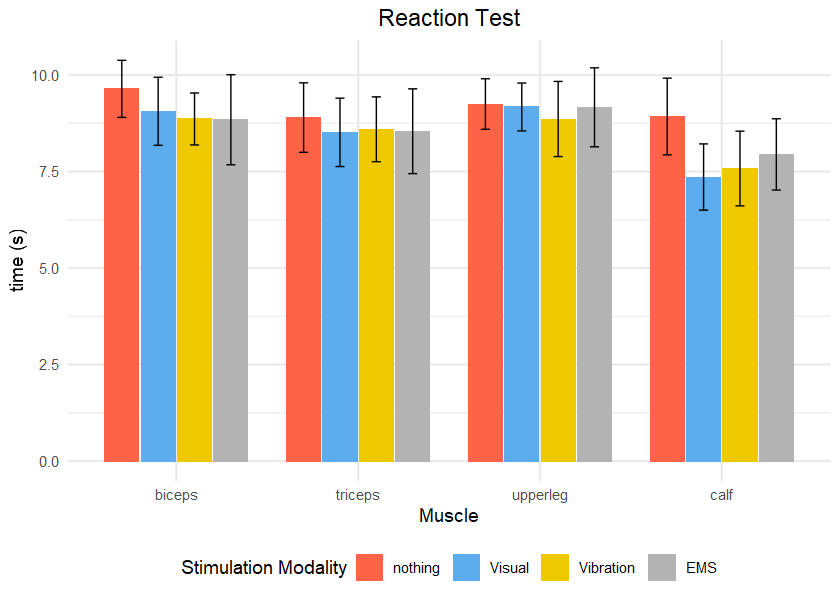

In [254]:
means$Modality <- factor(means$Modality, levels = c("nothing", "Visual", "Vibration", "EMS"))
means$Muscle <- factor(means$Muscle, levels = c("biceps", "triceps", "upperleg", "calf"))

plot <- ggplot(means, aes(y=ReactionTime, x=Muscle, fill=Modality)) +  
                        geom_bar(stat = "identity", position = position_dodge(width = 0.8), width=0.75) + 
                        geom_errorbar(aes(ymin = ReactionTime - ReactionTimeCI, ymax = ReactionTime + ReactionTimeCI),
                                      width=.2, position = position_dodge(width = 0.8), size = 0.3) + 
                       # coord_cartesian(ylim=c(5,12)) +  
                        ggtitle("Reaction Test") + 
                        ylab("time (s)") + 
                        labs(fill="Stimulation Modality  ") +
                        xlab("Muscle") + 
                        theme_minimal()  + 
                       # geom_signif(comparisons=list(c("True", "False")), annotations="p = 0.033", y_position = 6.75, tip_length = 0.1, vjust=-0.6) +
                        scale_fill_manual(values = cbPalette) +
                        theme(
                            plot.title = element_text(hjust = 0.5),
                            legend.position="bottom"
                        )
                                         
options(repr.plot.width = 7, repr.plot.height = 5) 
plot

ggsave("ReactionTimes.pdf", plot, width=6, height=4, device=cairo_pdf)

In [183]:
aov <- anova_test(data = timesPerSubject, dv = RT, wid = SubjectID, within = c(Muscle, Modality), effect.size = "pes")
get_anova_table(aov, correction = "auto") 

,Effect,DFn,DFd,F,p,p<.05,pes
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,Muscle,3,36,3.569,0.023,*,0.229
2,Modality,3,36,4.531,0.009,*,0.274
3,Muscle:Modality,9,108,0.827,0.593,,0.064


In [184]:
pairwise.t.test(timesPerSubject$RT, timesPerSubject$Modality, p.adj = "bonf", paired = TRUE)
pairwise.t.test(timesPerSubject$RT, timesPerSubject$Muscle, p.adj = "bonf", paired = TRUE)


	Pairwise comparisons using paired t tests 

data:  timesPerSubject$RT and timesPerSubject$Modality 

          EMS    nothing Vibration
nothing   0.0653 -       -        
Vibration 1.0000 0.0089  -        
Visual    1.0000 0.0410  1.0000   

P value adjustment method: bonferroni 


	Pairwise comparisons using paired t tests 

data:  timesPerSubject$RT and timesPerSubject$Muscle 

         biceps  calf    triceps
calf     0.00065 -       -      
triceps  0.42322 0.12234 -      
upperleg 1.00000 0.00340 0.67327

P value adjustment method: bonferroni 

,trialTimeS,Muscle,Modality,EMGValue,EMGValueNormalized,EMGTKEOValue,EMGTKEOValueNormalized,EMGSmoothedValueNormalized
,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,biceps,EMS,32970.65,0.4700691,33711613,0.02694069,0.1957500
2,2,biceps,EMS,32918.76,0.4896164,42190825,0.03240417,0.1749583
3,3,biceps,EMS,33014.16,0.4925038,47763305,0.03724215,0.1744976
4,4,biceps,EMS,32758.39,0.4947530,27502592,0.02227838,0.1854497
5,5,biceps,EMS,32798.67,0.4974369,25687983,0.02022182,0.1923979
6,6,biceps,EMS,32886.91,0.5123157,22269016,0.02119675,0.1946154


`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 1358 rows containing non-finite values (`stat_smooth()`)."
Warning message:
"Removed 259 rows containing missing values (`geom_line()`)."
`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 1358 rows containing non-finite values (`stat_smooth()`)."
Warning message:
"Removed 259 rows containing missing values (`geom_line()`)."


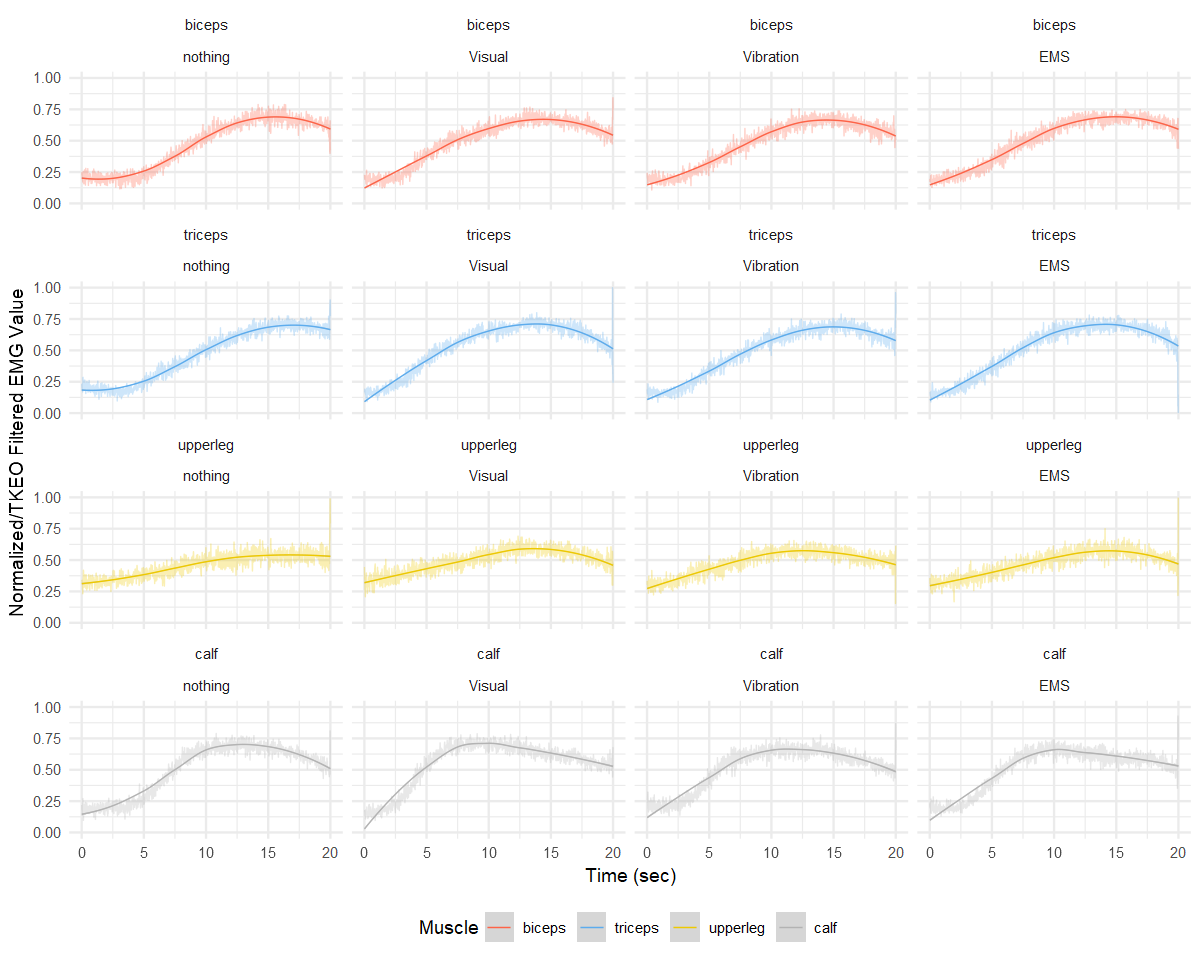

In [274]:
# The reaction curves
data$trialTimeS <- round(data$trialTime, 2) 

meanData <- aggregate(cbind(EMGValue, EMGValueNormalized, EMGTKEOValue, EMGTKEOValueNormalized, EMGSmoothedValueNormalized) ~ as.factor(trialTimeS) + Muscle + Modality, data, mean)
colnames(meanData) <- c("trialTimeS", "Muscle","Modality", "EMGValue", "EMGValueNormalized", "EMGTKEOValue", "EMGTKEOValueNormalized", "EMGSmoothedValueNormalized")
meanData$trialTimeS <- as.numeric(meanData$trialTimeS)
#head(data)
head(meanData)

meanData$Modality <- factor(meanData$Modality, levels = c("nothing", "Visual", "Vibration", "EMS"))
meanData$Muscle <- factor(meanData$Muscle, levels = c("biceps", "triceps", "upperleg", "calf"))

# beautiful TKEO corrected sample 
plot <- ggplot(meanData , aes(x = trialTimeS/ 100, y = EMGSmoothedValueNormalized, color = Muscle)) +  
            facet_wrap(. ~ Muscle + Modality) + 
            #geom_errorbar(aes(ymin = mean, ymax = mean), width=0, alpha=0.5, size=0.5) +  
            scale_x_continuous(breaks = scales::breaks_width(5), limits=c(0,20)) +
            #coord_cartesian(ylim = c(0, 0.2), expand = FALSE) + 
            #scale_y_continuous(breaks = scales::breaks_width(0.1), limits=c(0,0.3)) +
            geom_line(size = 0.3, alpha = .3) + 
            geom_smooth(size = 0.3, method = 'loess') +
            #geom_smooth() +
            #ggtitle("GSR Signal Stress Test") +
            #geom_wrap(.~Muscle) + 
            ylab("Normalized/TKEO Filtered EMG Value") + 
            #geom_point(data = peaks, aes(x=pos/10,y=val, color="blue"))+
            xlab("Time (sec)") +  
            scale_color_manual(values = cbPalette) +
            scale_fill_manual(values = cbPalette) +
            theme_minimal() + 
            theme(
                plot.title = element_text(hjust = 0.5),
                legend.position = "bottom"
            ) 
options(repr.plot.width = 10, repr.plot.height = 8) 
plot
ggsave("ReactionCurves.pdf", plot, width=10, height=8, device=cairo_pdf)

[1] "ANOVA on EMG Amplitude with Experiment Time as Continous Factor"



Error: SubjectID
                              Df    Sum Sq  Mean Sq F value Pr(>F)
as.numeric(trialTimeS)         1  82042473 82042473   2.924  0.148
Muscle                         3 137941525 45980508   1.639  0.293
as.numeric(trialTimeS):Muscle  3  16728131  5576044   0.199  0.893
Residuals                      5 140304807 28060961               

Error: Within
                                   Df    Sum Sq   Mean Sq F value Pr(>F)    
as.numeric(trialTimeS)              1 1.466e+05 1.466e+05   0.024  0.877    
Muscle                              3 1.112e+10 3.705e+09 607.830 <2e-16 ***
as.numeric(trialTimeS):Muscle       3 1.107e+07 3.691e+06   0.605  0.611    
Residuals                     2148944 1.310e+13 6.096e+06                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

[1] "ANOVA on EMG Amplitude with Experiment Time as Discrete Factor"



Error: SubjectID
                  Df    Sum Sq  Mean Sq F value Pr(>F)
trialTimeS         1  82042473 82042473   2.924  0.148
Muscle             3 137941525 45980508   1.639  0.293
trialTimeS:Muscle  3  16728131  5576044   0.199  0.893
Residuals          5 140304807 28060961               

Error: Within
                       Df    Sum Sq   Mean Sq F value Pr(>F)    
trialTimeS              1 1.466e+05 1.466e+05   0.024  0.877    
Muscle                  3 1.112e+10 3.705e+09 607.830 <2e-16 ***
trialTimeS:Muscle       3 1.107e+07 3.691e+06   0.605  0.611    
Residuals         2148944 1.310e+13 6.096e+06                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

,trialTimeS,Muscle,Modality,EMGValue,EMGValueNormalized,EMGTKEOValue,EMGTKEOValueNormalized,EMGSmoothedValueNormalized
,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,biceps,EMS,32870.60,0.5635576,32446973,0.03103170,0.4741693
2,2,biceps,EMS,32840.05,0.4486222,144003733,0.07642887,0.5638610
3,3,biceps,EMS,32830.60,0.4911028,102222398,0.05763007,0.4390347
4,4,biceps,EMS,32859.47,0.4693517,49491393,0.05565530,0.4572505
5,5,biceps,EMS,32867.43,0.5640500,53895107,0.05520218,0.4901512
6,6,biceps,EMS,32835.10,0.4771362,144822991,0.11697428,0.6463161


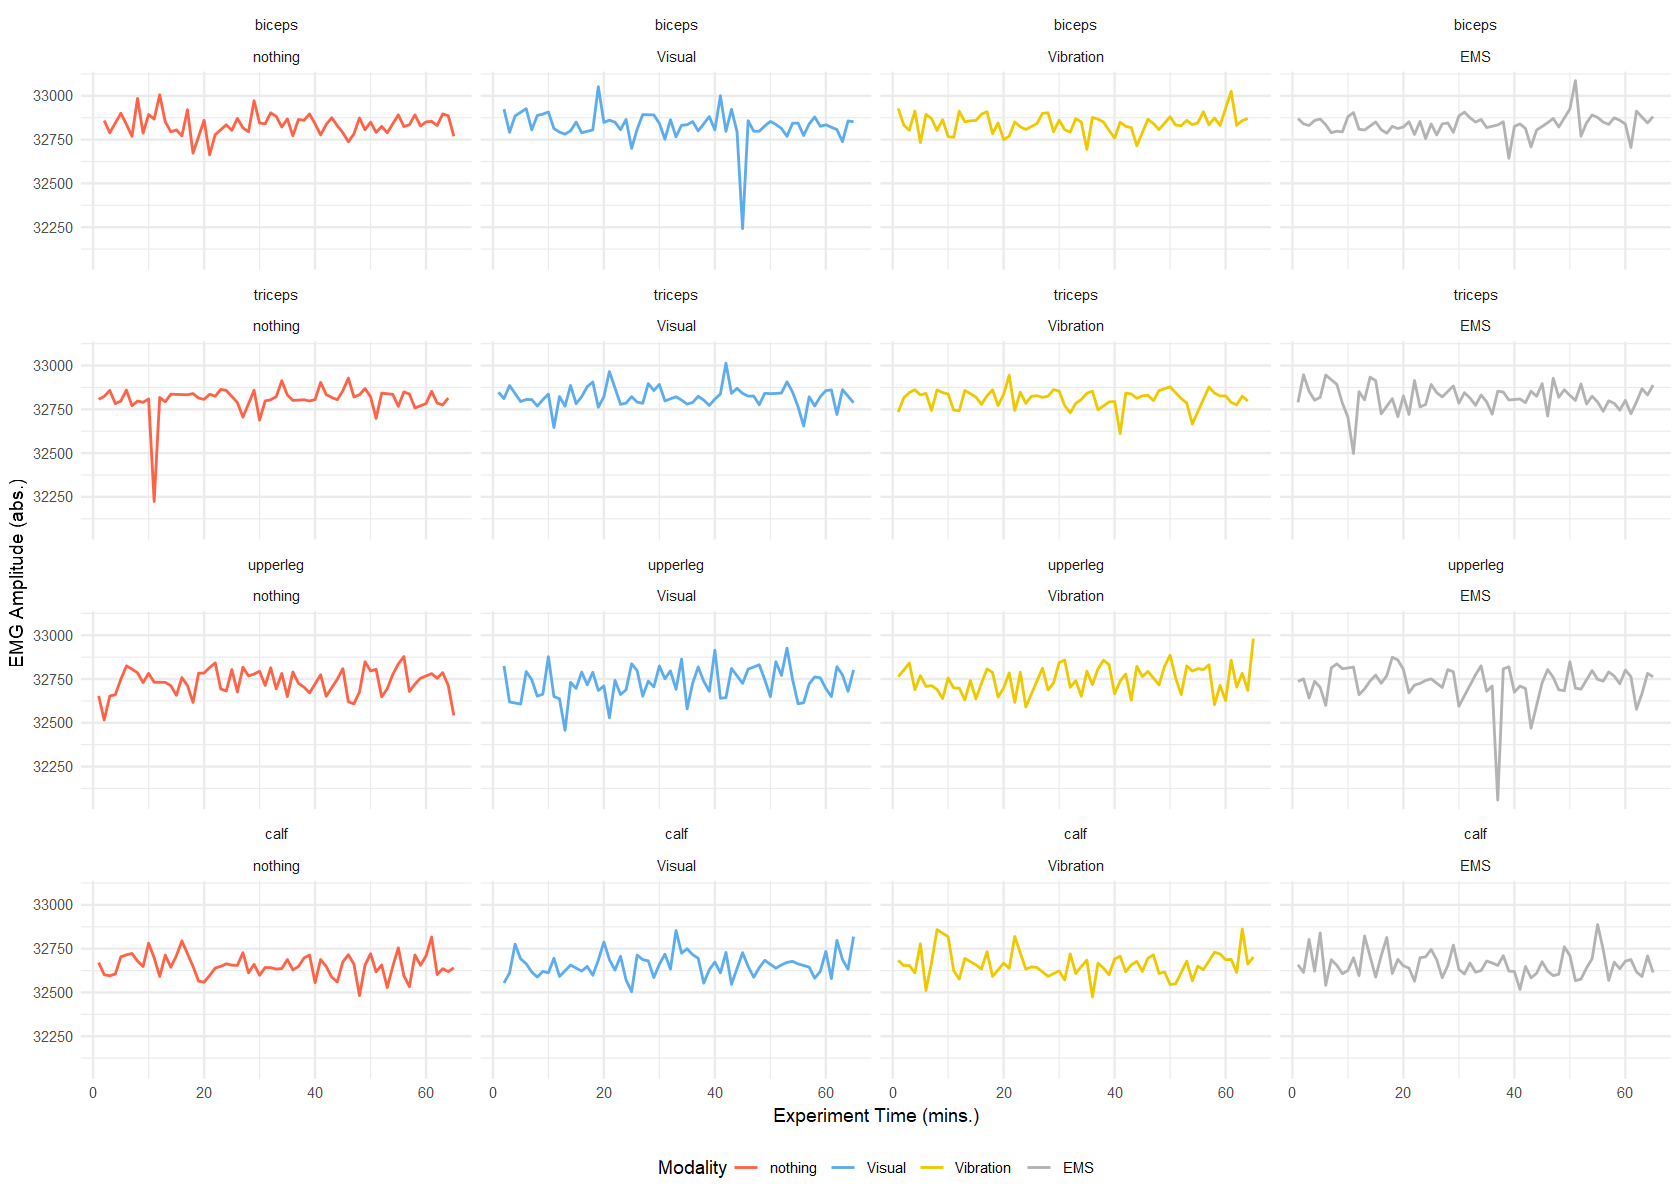

In [256]:
# Does Amplitude change over time?

data$trialTimeS <- round(data$experimentTime/1000/60, 2) 

meanData <- aggregate(cbind(EMGValue, EMGValueNormalized, EMGTKEOValue, EMGTKEOValueNormalized, EMGSmoothedValueNormalized) ~ as.factor(trialTimeS) + Muscle + Modality, data, mean)
colnames(meanData) <- c("trialTimeS", "Muscle","Modality", "EMGValue", "EMGValueNormalized", "EMGTKEOValue", "EMGTKEOValueNormalized", "EMGSmoothedValueNormalized")
meanData$trialTimeS <- as.numeric(meanData$trialTimeS)

#lm <- lm(EMGValue ~ as.numeric(trialTimeS) + Muscle , meanData)
#summary(lm)

print("ANOVA on EMG Amplitude with Experiment Time as Continous Factor")
aov <- aov(EMGValue ~ as.numeric(trialTimeS) * Muscle + Error(SubjectID), data)
summary(aov)

print("ANOVA on EMG Amplitude with Experiment Time as Discrete Factor")
aov <- aov(EMGValue ~ trialTimeS * Muscle + Error(SubjectID), data)
summary(aov)

head(meanData)

meanData$Modality <- factor(meanData$Modality, levels = c("nothing", "Visual", "Vibration", "EMS"))
meanData$Muscle <- factor(meanData$Muscle, levels = c("biceps", "triceps", "upperleg", "calf"))

# beautiful TKEO corrected sample 
plot <- ggplot(meanData , aes(x = trialTimeS, y = EMGValue, color = Modality, group = Muscle)) +  
            facet_wrap(. ~ Muscle + Modality) + 
            #geom_errorbar(aes(ymin = mean, ymax = mean), width=0, alpha=0.5, size=0.5) +  
           # scale_x_continuous(breaks = scales::breaks_width(5), limits=c(0,20)) +
            #coord_cartesian(ylim = c(0, 0.2), expand = FALSE) + 
            #scale_y_continuous(breaks = scales::breaks_width(0.1), limits=c(0,0.3)) +
            geom_line(size = 0.6) + 
            #geom_smooth(size = 0.3, method = 'loess') +
            #geom_smooth() +
            #ggtitle("GSR Signal Stress Test") +
            #geom_wrap(.~Muscle) + 
            ylab("EMG Amplitude (abs.)") + 
            #geom_point(data = peaks, aes(x=pos/10,y=val, color="blue"))+
            xlab("Experiment Time (mins.)") + 
            #labs(color="Task", linetype="Room") + 
            scale_color_manual(values = cbPalette) +
            theme_minimal() + 
            theme(
                plot.title = element_text(hjust = 0.5),
                legend.position = "bottom"
            ) 
options(repr.plot.width = 14, repr.plot.height = 10) 
plot

# No

SubjectID,Muscle,Modality,Timing,Trial,ReactionTime,ExperimentTime
<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>
106,biceps,EMS,11,1,11.215680,35069.094
106,biceps,EMS,13,1,9.102784,34288.802
106,biceps,EMS,13,2,12.515392,19684.929
106,biceps,EMS,3,1,11.854016,1580.191
106,biceps,EMS,5,1,8.174464,14203.517
106,biceps,EMS,7,1,6.765120,25426.445


SubjectID,Muscle,Modality,Timing,Trial,ReactionTime,ExperimentTime,ExperimentTimeFct
<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>
106,biceps,EMS,11,1,11.215680,35069.094,6
106,biceps,EMS,13,1,9.102784,34288.802,6
106,biceps,EMS,13,2,12.515392,19684.929,3
106,biceps,EMS,3,1,11.854016,1580.191,0
106,biceps,EMS,5,1,8.174464,14203.517,2
106,biceps,EMS,7,1,6.765120,25426.445,4


[1] "ANOVA on Reaction Time with Experiment Time as Discrete Factor"



Error: SubjectID
                         Df Sum Sq Mean Sq
ExperimentTimeFct         6  440.6   73.43
Muscle                    3   89.6   29.87
ExperimentTimeFct:Muscle  3  121.9   40.62

Error: SubjectID:ExperimentTimeFct
                         Df Sum Sq Mean Sq F value Pr(>F)
ExperimentTimeFct         6   65.0  10.841   0.920  0.488
Muscle                    3   37.9  12.633   1.072  0.369
ExperimentTimeFct:Muscle 18  141.0   7.831   0.665  0.828
Residuals                51  600.7  11.779               

Error: SubjectID:Muscle
                         Df Sum Sq Mean Sq F value  Pr(>F)   
Muscle                    3  358.5  119.50   5.818 0.00582 **
ExperimentTimeFct:Muscle 18  653.3   36.30   1.767 0.11833   
Residuals                18  369.7   20.54                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Error: Within
                           Df Sum Sq Mean Sq F value Pr(>F)
ExperimentTimeFct:Muscle   18     99   5.523    0.65  0.862
Residuals

[1] " "
[1] "ANOVA on Reaction Time with Experiment Time as Continous Factor"



Error: SubjectID
                      Df Sum Sq Mean Sq F value Pr(>F)  
ExperimentTime         1 243.72  243.72   5.696 0.0626 .
Muscle                 3 109.25   36.42   0.851 0.5229  
ExperimentTime:Muscle  3  85.12   28.37   0.663 0.6095  
Residuals              5 213.94   42.79                 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Error: SubjectID:ExperimentTime
                      Df Sum Sq Mean Sq F value Pr(>F)
ExperimentTime         1  17.54  17.543   3.563  0.108
Muscle                 3  19.86   6.621   1.345  0.346
ExperimentTime:Muscle  3  38.90  12.966   2.633  0.144
Residuals              6  29.55   4.924               

Error: SubjectID:Muscle
                      Df Sum Sq Mean Sq F value Pr(>F)  
Muscle                 3  353.3  117.77   3.682 0.0216 *
ExperimentTime:Muscle  3   57.8   19.26   0.602 0.6182  
Residuals             33 1055.6   31.99                 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

E

Muscle,ExperimentTimeFct,RT,RTCI,ET,N
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<int>
biceps,0,9.316281,1.1941303,1419.185,28
biceps,1,9.298268,0.7340729,6072.767,64
biceps,2,9.293524,0.8916445,12095.714,50
biceps,3,8.885170,0.7648105,17891.262,65
biceps,4,8.762023,0.8355547,23902.408,53
biceps,5,8.899172,0.8438853,30067.940,48


`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


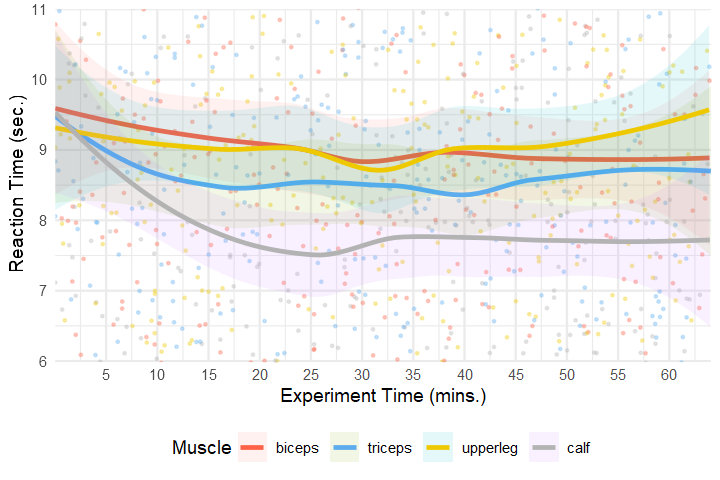

In [275]:
# Does reaction time depends on experimental time and muscle?

findBulgeStart <- function(x, y){
    cc <- check_curve(x, y)
    #ipbese <- bese(x, y, cc$index)
    ipbede <- bede(x, y, cc$index)
    #ipbede <- ifelse(!is.na(ipbede), ipbede, 20)
    return(as.numeric(ipbede$iplast))
}

timePerSubject <- data %>% group_by(SubjectID, Muscle, Modality, Timing, Trial) %>% 
    summarize(ReactionTime = findBulgeStart(trialTime, EMGSmoothedValueNormalized),
              ExperimentTime = max(experimentTime),
              .groups = 'drop')

timePerSubject <- na.omit(timePerSubject) 
head(timePerSubject)
timePerSubject$ExperimentTimeFct <- as.factor(round(timePerSubject$ExperimentTime/ 6000,0))

head(timePerSubject)

print("ANOVA on Reaction Time with Experiment Time as Discrete Factor")
aov <- aov(ReactionTime ~ ExperimentTimeFct * Muscle + Error(SubjectID / (ExperimentTimeFct + Muscle)), timePerSubject)
summary(aov)

print(" ")
print("ANOVA on Reaction Time with Experiment Time as Continous Factor")
aov <- aov(ReactionTime ~ ExperimentTime * Muscle + Error(SubjectID / (ExperimentTime + Muscle)), timePerSubject)
summary(aov) 

means <- timePerSubject %>% group_by(Muscle, ExperimentTimeFct) %>% 
    summarize(RT = mean(ReactionTime),
              RTCI = qt(1 - (0.05 / 2), df = n()-1) * sd(ReactionTime) / sqrt(n()), 
              ET = mean(ExperimentTime),
              N = n(),
              .groups = 'drop')  

means <- na.omit(means) 
head(means)

#means$Modality <- factor(meanData$Modality, levels = c("nothing", "Visual", "Vibration", "EMS"))
timePerSubject$Muscle <- factor(timePerSubject$Muscle, levels = c("biceps", "triceps", "upperleg", "calf"))
means$Muscle <- factor(means$Muscle, levels = c("biceps", "triceps", "upperleg", "calf"))

# beautiful TKEO corrected sample 
plot <- ggplot(timePerSubject, aes(x = ExperimentTime / 600, y = ReactionTime, color = Muscle, fill = Muscle)) +   
            #geom_errorbar(aes(ymin = mean, ymax = mean), width=0, alpha=0.5, size=0.5) +  
            scale_x_continuous(breaks = scales::breaks_width(5)) +
            coord_cartesian(ylim = c(6, 11), expand = FALSE) + 
            #scale_y_continuous(breaks = scales::breaks_width(1), limits=c(6,11)) +
            #geom_line(size = 0.6) + 
            geom_point(alpha = 0.3, size = 0.3) + 
            #geom_smooth(size = 0.3, method = 'loess') +
            geom_smooth(alpha = 0.1) +
            #ggtitle("GSR Signal Stress Test") +
            #geom_wrap(.~Muscle) + 
            ylab("Reaction Time (sec.)") + 
            #geom_point(data = peaks, aes(x=pos/10,y=val, color="blue"))+
            xlab("Experiment Time (mins.)") + 
            #labs(color="Task", linetype="Room") + 
            scale_color_manual(values = cbPalette) +
            theme_minimal() + 
            theme(
                plot.title = element_text(hjust = 0.5),
                legend.position = "bottom"
            ) 
options(repr.plot.width = 6, repr.plot.height = 4) 
plot
ggsave("FatigueVSLearning.pdf", plot, width=6, height=4, device=cairo_pdf)

# Muscle

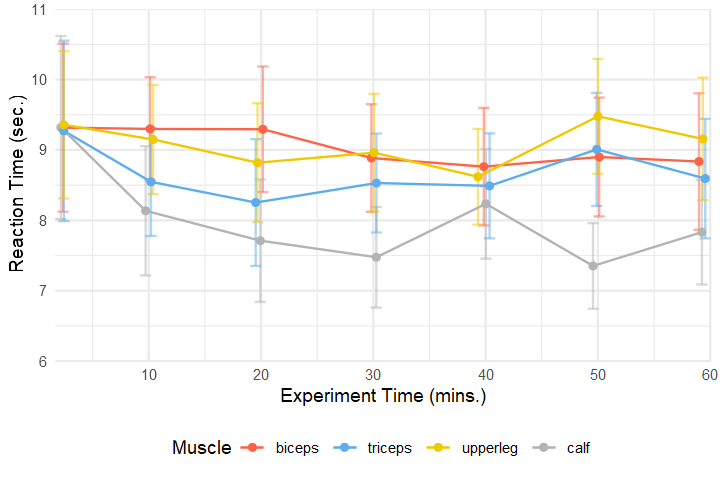

In [267]:
plot <- ggplot(means, aes(x = ET / 600, y = RT, color = Muscle, fill = Muscle)) +   
            geom_errorbar(aes(ymin = RT - RTCI, ymax = RT + RTCI), width=1, alpha=0.5, size=0.5) +  
           # scale_x_continuous(breaks = scales::breaks_width(5), limits=c(0,20)) +
            coord_cartesian(ylim = c(6, 11), expand = FALSE) + 
            #scale_y_continuous(breaks = scales::breaks_width(1), limits=c(6,11)) +
            geom_line() + 
            geom_point() +  
            #ggtitle("GSR Signal Stress Test") +
            #geom_wrap(.~Muscle) + 
            ylab("Reaction Time (sec.)") + 
            #geom_point(data = peaks, aes(x=pos/10,y=val, color="blue"))+
            xlab("Experiment Time (mins.)") + 
            #labs(color="Task", linetype="Room") + 
            scale_color_manual(values = cbPalette) +
            theme_minimal() + 
            theme(
                plot.title = element_text(hjust = 0.5),
                legend.position = "bottom"
            ) 
options(repr.plot.width = 6, repr.plot.height = 4) 
plot